In [1]:
import vidaug.augmentors as va
from PIL import Image, ImageSequence
import random
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
import pickle

from typing import List, Tuple, Dict
import ffmpeg as ff

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore') 

/home/ssrlab/ENTER/envs/cuda_test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_gt = pd.read_csv('/home/ssrlab/kw/2023_2/Industry_Project/Industry-Project/ai/dataset/train.csv',encoding='EUC-KR')
test_gt = pd.read_csv('/home/ssrlab/kw/2023_2/Industry_Project/Industry-Project/ai/dataset/test.csv', encoding='EUC-KR')

In [3]:
sometimes = lambda aug: va.Sometimes(1, aug) # Used to apply augmentor with 100% probability
seq = va.Sequential([ # randomly rotates the video with a degree randomly choosen from [-10, 10]  
    sometimes(va.Salt(ratio=5)) # horizontally flip the video with 100% probability
])

def get_number_of_frames(file_path: str) -> int:
    probe = ff.probe(filePath)
    video_streams = [stream for stream in probe["streams"] if stream["codec_type"] == "video"]
    #width = video_streams[0]['coded_width']
    #height = video_streams[0]['coded_height']
    del probe
    return video_streams[0]['nb_frames']

def extract_N_video_frames(file_path: str) -> List[np.ndarray]:
    nb_frames = int(get_number_of_frames(file_path= filePath))
    
    div = 30
    div_frames = nb_frames / div
    temp = 0
    video_frames = []
    print('이번 영상은')
    cap = cv2.VideoCapture(filePath)
    for ind in range(30):
        cap.set(1,int(temp))
        temp += div_frames
        res, frame = cap.read()
        video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    video_frames = seq(video_frames)
    print('개수 = ', len(video_frames))
    del cap
    return video_frames

def resize_image(image: np.ndarray, new_size: Tuple[int,int]) -> np.ndarray:
    return cv2.resize(image, new_size, interpolation = cv2.INTER_AREA)

def preprocessing_input(file_path: str, file_name: str, gt = train_gt, training: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    sampled = extract_N_video_frames(file_path= filePath)
    resized_images = [resize_image(image= im, new_size= (224,224)) for im in sampled]
    preprocessed_video = np.stack(resized_images)
    if sampled == None:
        print(file_name)
    for i in range(len(gt)):
        if gt.loc[i,'path'] == file_name:
            video_gt = gt.loc[i,'label']
    return (preprocessed_video, video_gt)

In [4]:
training_set_data = []

path = '/home/ssrlab/kw/2023_2/Industry_Project/Industry-Project/ai/dataset/TRAIN'
i=1
for filename in os.listdir(path):
    filePath = path+'/'+filename
    training_set_data.append(preprocessing_input(file_path= filePath, file_name= filename, gt= train_gt, training= True))
    print(i)
    i+=1
    break

이번 영상은
개수 =  30
1


In [5]:
def reshape_to_expected_input(dataset: List[Tuple[np.ndarray, np.ndarray]]) -> Tuple[np.ndarray,np.ndarray]:
    
    x0_list = []
    y_list = []
    for i in range(0,len(dataset)):
        x0_list.append(dataset[i][0])
        y_list.append(dataset[i][1])
    return (np.stack(x0_list),np.stack(y_list))

In [6]:
train_input = reshape_to_expected_input(dataset= training_set_data)
del training_set_data

In [7]:
# savename = 'training_set(Salt).dat'
# with open(savename, "wb") as f:
#     pickle.dump(train_input, f)

# 아래는 예시

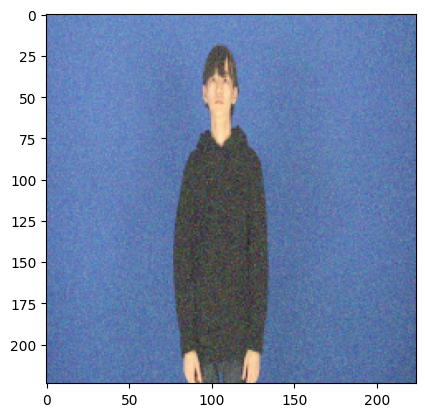

In [8]:
plt.imshow(train_input[0][0][21])

In [9]:
import imageio

In [10]:
imageio.mimsave('test.gif', train_input[0][0], 'GIF', duration=1.0)